In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
logs_df_statistical_method = pd.read_csv("/content/drive/MyDrive/logs_df_statistical_method.csv")
logs_df_statistical_method.head()

Unnamed: 0  request_processing_time  target_processing_time  \
0           0                    0.000                   0.759   
1           1                    0.001                   0.194   
2           2                    0.001                   0.444   
3           3                    0.000                   0.221   
4           4                    0.001                   0.168   

   response_processing_time  received_bytes  sent_bytes  number of requests  
0                       0.0             375         542                   1  
1                       0.0             374        2363                   5  
2                       0.0             374         542                   7  
3                       0.0             375        5641                   8  
4                       0.0             375        2532                   8

In [4]:
logs_df_statistical_method.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
logs_df_statistical_method.shape

(100000, 6)

# Statistical model

Cutoff hi > 2 * (p + 1) / n was too small as all observations were marked as unusual. We will use hi > 3 * (p + 1) / n cutoff instead.

In [6]:
# statistical model unidimensional case
anomalies_features = list()
anomalies_indices = list()
for column in logs_df_statistical_method.columns:
    for i in tqdm(range(1, logs_df_statistical_method.shape[0])):
        if i == 1:
          current_mean = np.mean(logs_df_statistical_method[column][:2])
        else:
          current_mean = ((i - 1) * previous_mean + logs_df_statistical_method[column][i]) * 1/i
        leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
        if leverage_statistic > (3 * 2) / i: # hi > 3 * (p + 1) / n
            anomalies_features.append(column)
            anomalies_indices.append(i)
        previous_mean = current_mean

  0%|          | 0/99999 [00:00<?, ?it/s]<ipython-input-6-b8314c851986>:10: RuntimeWarning: divide by zero encountered in double_scalars
  leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
  0%|          | 0/99999 [00:00<?, ?it/s]<ipython-input-6-b8314c851986>:10: RuntimeWarning: invalid value encountered in double_scalars
  leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
100%|██████████| 99999/99999 [00:39<00:00, 2552.47it/s]


In [7]:
# analyzing the output
len(set(anomalies_indices))

99998

In [8]:
# analyzing the output
np.unique(np.array(anomalies_features), return_counts=True)

(array(['number of requests', 'received_bytes', 'request_processing_time',
        'response_processing_time', 'sent_bytes', 'target_processing_time'],
       dtype='<U24'),
 array([99998, 99994, 99933, 99627, 99987, 99967]))

Feature number_of_requests was not cause of any anomaly

In [9]:
# statistical model multidimensional case
anomalies_indices_md = list()
leverage_statistics = list()
design_matrix_product_inverse = np.linalg.inv(np.dot(np.transpose(logs_df_statistical_method.to_numpy()), logs_df_statistical_method.to_numpy()))
for i in tqdm(range(1, logs_df_statistical_method.shape[0])):
  leverage_statistic = np.dot(np.dot(np.transpose(logs_df_statistical_method.iloc[0].to_numpy()), design_matrix_product_inverse), logs_df_statistical_method.iloc[0].to_numpy())
  leverage_statistics.append(leverage_statistic)
  if leverage_statistic > (3 * (7)) / i: # hi > 3 * (p + 1) / n
    anomalies_indices_md.append(i)

100%|██████████| 99999/99999 [00:17<00:00, 5690.65it/s]


In [10]:
# analyzing the output
len(anomalies_indices_md)

0

In [11]:
set(anomalies_indices).intersection(set(anomalies_indices_md))

set()

In [12]:
len(set(anomalies_indices).difference(set(anomalies_indices_md)))

99998

# Probabilistic model

In [13]:
import math

In [14]:
# probabilistic model request_processing_time
# ARIMA(0, 0, 0) with constant 4 e-04
request_processing_time_anomalies = list(logs_df_statistical_method["request_processing_time"][abs(logs_df_statistical_method["request_processing_time"]) > 4 * pow(10, -4) + 2 * math.sqrt(2)].index)
len(request_processing_time_anomalies)

0

In [15]:
# probabilistic model response_processing_time
# ARIMA(5, 1, 0)
ar_params = [-0.8352, -0.6647, -0.4993, -0.3295, -0.1647]
diff_variance = np.var(logs_df_statistical_method["response_processing_time"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
response_processing_time_anomalies = list(logs_df_statistical_method["response_processing_time"].diff()[1:][abs(logs_df_statistical_method["response_processing_time"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(request_processing_time_anomalies)

0

In [16]:
# probabilistic model target_processing_time
# ARIMA(1, 1, 0) with drift
ar_params = [-0.4890]
diff_variance = np.var(logs_df_statistical_method["target_processing_time"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
target_processing_time_anomalies = list(logs_df_statistical_method["target_processing_time"].diff()[1:][abs(logs_df_statistical_method["target_processing_time"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(target_processing_time_anomalies)

4306

Text(0.5, 1.0, 'target_processing_time_anomalies anomalies plot')

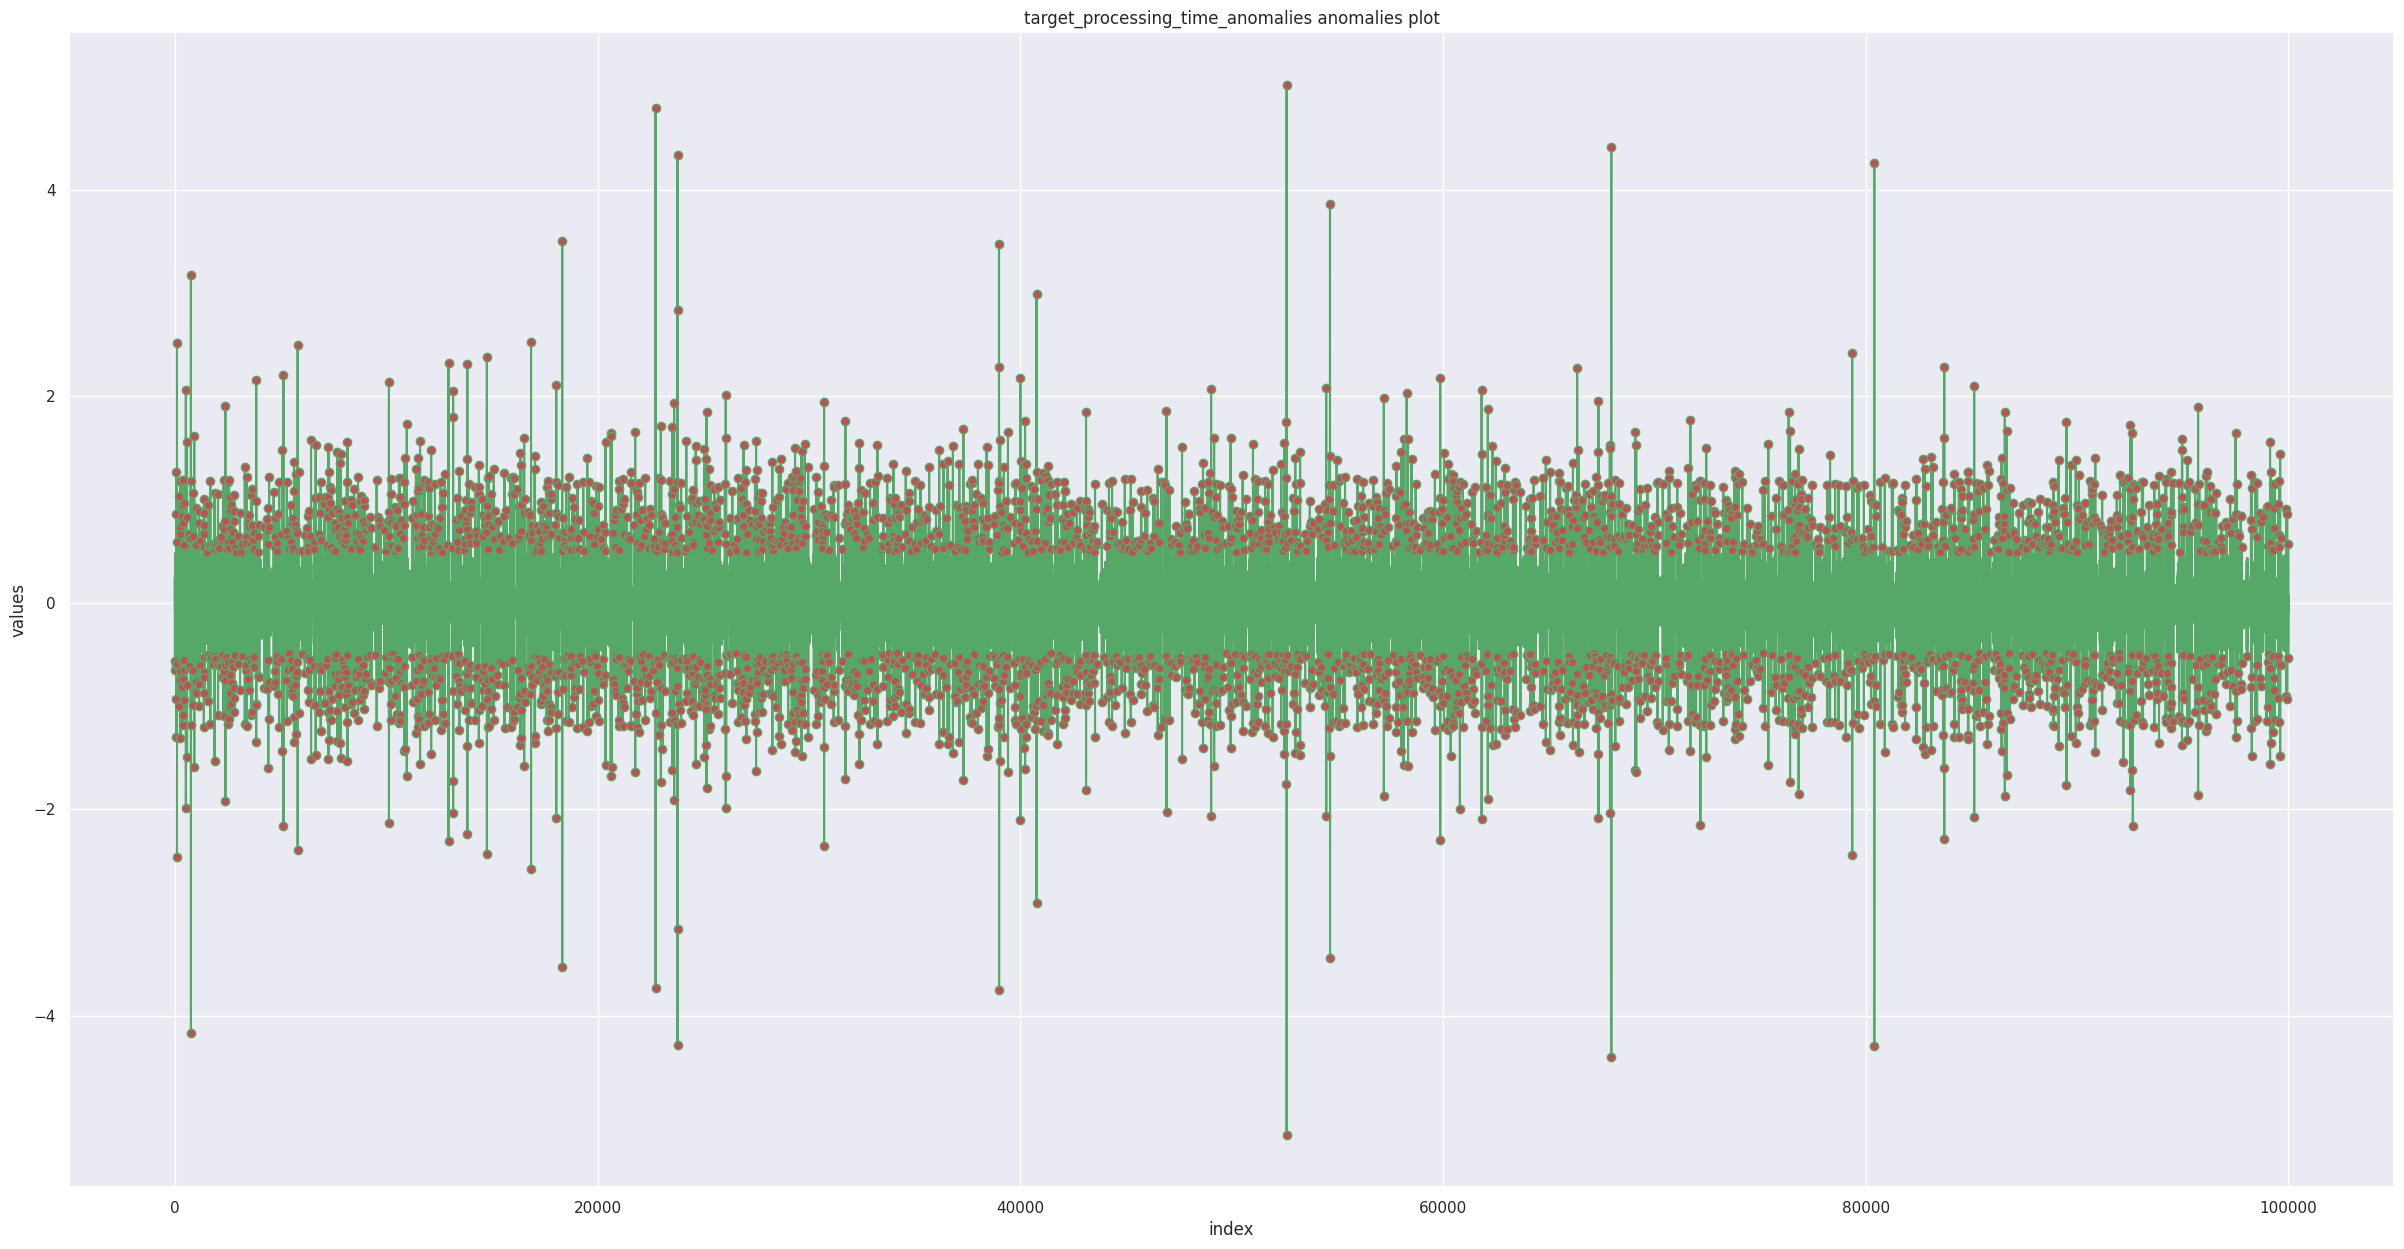

In [17]:
sns.set()
plt.figure(figsize=(30,15))
plt.plot(logs_df_statistical_method["target_processing_time"].diff().index, logs_df_statistical_method["target_processing_time"].diff(), '-go', markevery=target_processing_time_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('target_processing_time_anomalies anomalies plot')

In [18]:
# probabilistic model received_bytes
# ARIMA(0, 1, 1)
received_bytes_anomalies = list((logs_df_statistical_method["received_bytes"].diff()[1:][abs(logs_df_statistical_method["received_bytes"].diff()[1:]) > 2 * math.sqrt(0.0099)]).index)
len(received_bytes_anomalies)

86763

Text(0.5, 1.0, 'received_bytes anomalies plot')

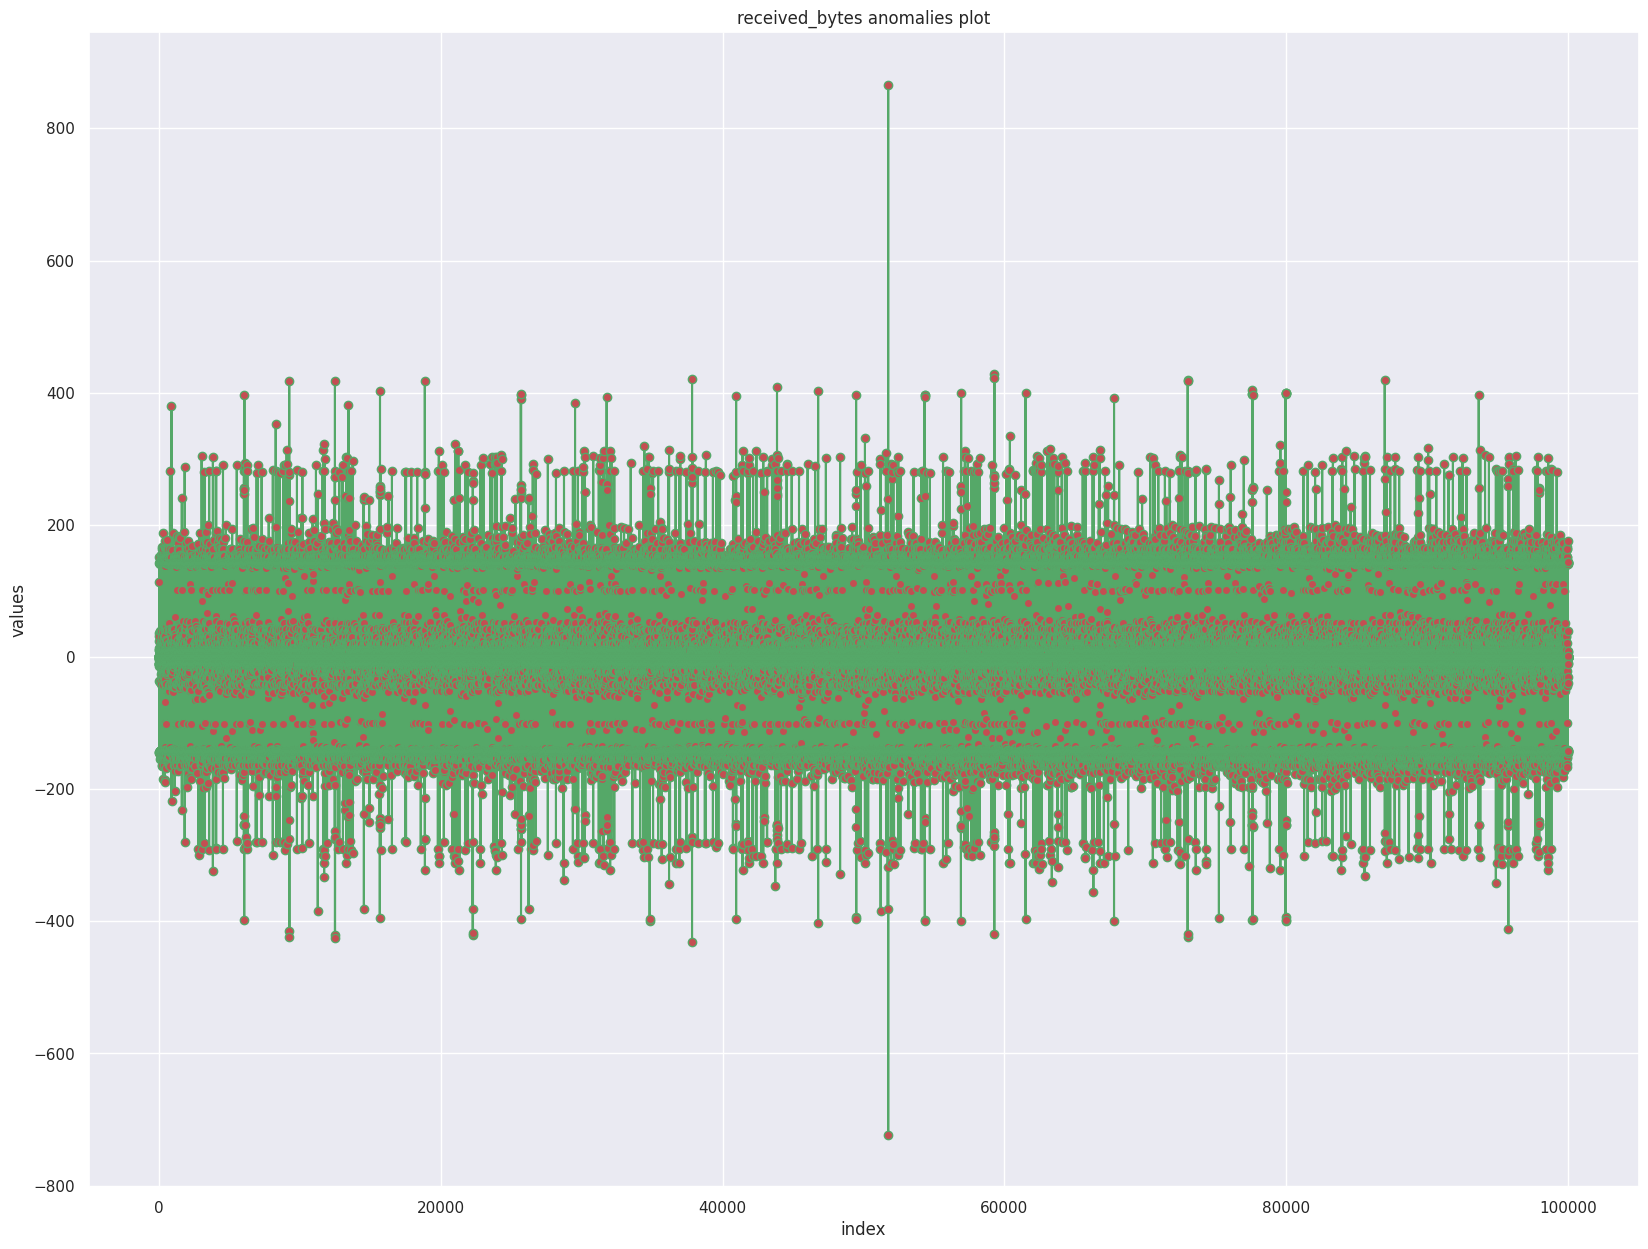

In [19]:
sns.set()
plt.figure(figsize=(20,15))
plt.plot(logs_df_statistical_method["received_bytes"].diff().index, logs_df_statistical_method["received_bytes"].diff(), '-go', markevery=received_bytes_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('received_bytes anomalies plot')

In [20]:
# probabilistic model sent_bytes
# ARIMA(5, 1, 0)
ar_params = [-0.8340, -0.6716, -0.5020, -0.3341 -0.1659]
diff_variance = np.var(logs_df_statistical_method["sent_bytes"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
sent_bytes_anomalies = list(logs_df_statistical_method["sent_bytes"].diff()[1:][abs(logs_df_statistical_method["sent_bytes"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(sent_bytes_anomalies)

8

Text(0.5, 1.0, 'sent_bytes anomalies plot')

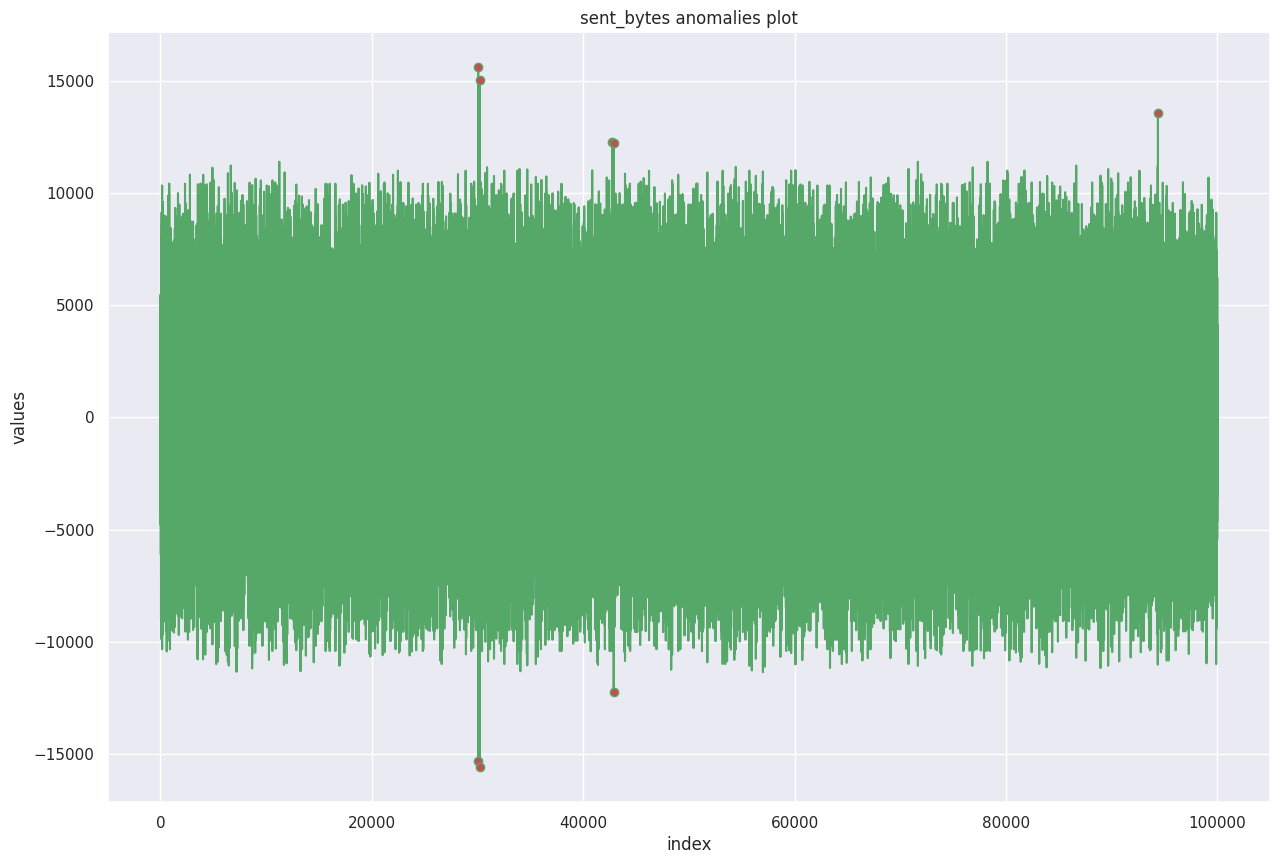

In [21]:
sns.set()
plt.figure(figsize=(15,10))
plt.plot(logs_df_statistical_method["sent_bytes"].diff().index, logs_df_statistical_method["sent_bytes"].diff(), '-go', markevery=sent_bytes_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('sent_bytes anomalies plot')

In [22]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [23]:
from fastparquet import ParquetFile
ohe_logs_df = ParquetFile('/content/drive/MyDrive/ohe_logs_df.parq')
ohe_logs_df = ohe_logs_df.to_pandas()

In [24]:
ohe_logs_df.head()

ohe_type0  ohe_type1  ohe_type2                       time  \
0          1          0          0 2023-05-03 23:55:00.847313   
1          1          0          0 2023-05-03 23:55:00.936341   
2          1          0          0 2023-05-03 23:55:00.980508   
3          1          0          0 2023-05-03 23:55:01.031178   
4          1          0          0 2023-05-03 23:55:01.052711   

   request_processing_time  target_processing_time  response_processing_time  \
0                    0.000                0.758789                       0.0   
1                    0.001                0.193970                       0.0   
2                    0.001                0.444092                       0.0   
3                    0.000                0.220947                       0.0   
4                    0.001                0.167969                       0.0   

   ohe_elb_status_code0  ohe_elb_status_code1  ohe_elb_status_code2  ...  \
0                     1                     0                     0  ...   
1                     1                     0                     0  ...   
2                     1                     0                     0  ...   
3                     1                     0                     0  ...   
4                     1                     0                     0  ...   

   ohe_target_group_arn1  ohe_target_group_arn2  ohe_domain_name0  \
0                      0                      1                 0   
1                      0                      1                 0   
2                      0                      1                 0   
3                      0                      1                 0   
4                      0                      1                 0   

   ohe_domain_name1  ohe_domain_name2  ohe_actions_executed0  \
0                 0                 1                      1   
1                 0                 1                      1   
2                 0                 1                      1   
3                 0                 1                      1   
4                 0                 1                      1   

   ohe_actions_executed1  ohe_redirect_url0  ohe_redirect_url1  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  1                  0   
3                      0                  1                  0   
4                      0                  1                  0   

   ohe_redirect_url2  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 47759 columns]

In [25]:
ohe_logs_df = pd.concat([ohe_logs_df, logs_df_statistical_method['number of requests']], axis=1)
ohe_logs_df.shape

(100000, 47760)

In [ ]:
ohe_logs_df = ohe_logs_df.set_index("time")
ohe_logs_df.drop("time", axis=1, inplace=True)

Deep LSTM network

In [26]:
import sklearn
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback

import re
import logging
import os
import sys

Exception ignored in: <function _xla_gc_callback at 0x7a0f7beca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [27]:
'''# Number of LSTM layers, default: 3
lstm_layers = int(os.environ.get('lstm_layers', '3'))

# Number of LSTM cells per layer, default: 10
lstm_cells_per_layer = int(os.environ.get('lstm_cells_per_layer', '10'))

# LSTM time steps, default: 10
timesteps = int(os.environ.get('timesteps', '10'))

# Time series dimensionality, default: 3
dim = ohe_logs_df.shape[0]

# batch size, default: 32
batch_size = int(os.environ.get('batch_size', '32'))

# epochs, default: 3
epochs = int(os.environ.get('epochs', '3'))'''

In [28]:
'''for element in sys.argv:
    logging.warning('argv raw ' +  element)

parameters = list(
    map(lambda s: re.sub('$', '"', s),
        map(
            lambda s: s.replace('=', '="'),
            filter(
                lambda s: s.find('=') > -1 and bool(re.match(r'[A-Za-z0-9_]*=[.\/A-Za-z0-9]*', s)),
                sys.argv
            )
    )))

lstm_layers = int(lstm_layers)
lstm_cells_per_layer = int(lstm_cells_per_layer)
timesteps = int(timesteps)
dim = int(dim)
batch_size = int(batch_size)


for parameter in parameters:
    exec(parameter)
    logging.warning('Parameter: ' + parameter)


for parameter in parameters:
    exec("logging.warning('final parameter: ' + str({}))".format(parameter.split('=')[0]))
    exec("logging.warning('final parameter type: ' + str(type({})))".format(parameter.split('=')[0]))'''

In [29]:
'''def scaleData(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)'''

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def generate_datasets_for_training(data, window_size, scale=True, scaler_type=StandardScaler):
  _l = len(data)
  data = scaler_type().fit_transform(data)
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  X_train, Y_train, X_test, Y_test = [np.array(x) for x in train_test_split(Xs, Ys)]
  assert X_train.shape[2] == X_test.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
  return  (X_train.shape[2], X_train, Y_train, X_test, Y_test)

In [ ]:
feats, X, Y, XX, YY = generate_datasets_for_training(, 4)

In [ ]:
epochs = 100
batch_size = 32
window_length = 4
from keras import metrics
import keras
import tensorflow as tf
import os

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

feats, X_train, Y_train, X_test, Y_test = generate_datasets_for_training(, 4)

model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3')) # return_sequences=False as next layer is keras.layers.RepeatVector
model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('LSTM_best_val_acc.h5',
                             monitor='val_mse',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [ ]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop]) # we can shuffle as windows have been defined

In [31]:
'''loss_history = []
loss_history_total = []

class LossHistory(Callback):
    def on_train_begin(self, logs):
        loss_history = []

    def on_train_batch_end(self, batch, logs):
        print('Loss on_train_batch_end ' + str(logs.get('loss')))
        loss_history.append(logs.get('loss'))
        loss_history_total.append(logs.get('loss'))'''

In [32]:
'''def create_model():
    model = Sequential()
    for _ in range(lstm_layers):
        model.add(LSTM(lstm_cells_per_layer, input_shape = (timesteps, dim), return_sequences=True))
    model.add(Dense(dim))
    model.compile(loss='mse', optimizer='adam')
    return model

model = create_model()
model.summary()

def train(data):
    model.fit(data, data, epochs=epochs, batch_size=batch_size, validation_data=(data, data), verbose=0, shuffle=False, callbacks=[LossHistory()])'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            4000440   
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10, 10)            840       
                                                                 
 dense (Dense)               (None, 10, 100000)        1100000   
                                                                 
Total params: 5102120 (19.46 MB)
Trainable params: 5102120 (19.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
'''def doNN(data):
    #data = scaleData(data)
    train(data)'''

In [ ]:
'''data = lstm_data_transform(ohe_logs_df[:, ohe_logs_df!= "time"], num_steps=timesteps)
doNN(data)'''